In [1]:
import numpy as np
import math

def mulproduct(n):
    ans = 1
    for i in range(1,n+1):
        ans *= i
    return ans

def possoin(lamda,trun):
    ans = [math.exp(-lamda) * (lamda**n) / mulproduct(n) for n in range(trun)]
    ans.append(1-sum(ans))
    return ans

#泊松分布
requested_cars_1 = possoin(3,20)
requested_cars_2 = possoin(4,20)
returned_cars_1 = possoin(3,20)
returned_cars_2 = possoin(2,20)

multivariate_p = np.zeros((21,21,21,21))
lefti = np.zeros((21,21,21,21),dtype=int)
leftj = np.zeros((21,21,21,21),dtype=int)

for state0 in range(21):
    for state1 in range(21):
        for i,p1 in enumerate(requested_cars_1):
            for k,p3 in enumerate(returned_cars_1):
                lefti[state0,state1,i,k] = int(min(max(state0,i)-i+k,20))
for state0 in range(21):
    for state1 in range(21):
        for j,p2 in enumerate(requested_cars_2):
            for l,p4 in enumerate(returned_cars_2):
                leftj[state0,state1,j,l] = int(min(max(state1,j)-j+l,20))
for i,p1 in enumerate(requested_cars_1):
    for k,p3 in enumerate(returned_cars_1):
        for j,p2 in enumerate(requested_cars_2):
            for l,p4 in enumerate(returned_cars_2):
                multivariate_p[i,j,k,l] = p1*p2*p3*p4
# multivariate_p /= np.sum(multivariate_p)  # 确保联合概率总和为 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def reward(requested, left):
    return np.minimum(left, requested) * 10

def possible_transitions(left1, left2):
    # 创建一个 21x21 的零数组
    transitions = np.zeros((21, 21), dtype=int)
    positions = []
    # 当前状态的车库剩余车辆数量
    for transfer in range(-5, 6):  # 转移的数量范围 -5 到 5
        new_left1 = left1 - transfer
        new_left2 = left2 + transfer  
        # 检查新的状态是否在有效范围内
        if 0 <= new_left1 <= 20 and 0 <= new_left2 <= 20:
            # transitions[new_left1, new_left2] = 1
            positions.append([new_left1,new_left2])
    return positions

def cost(gap):
    return gap

# 计算Q(state,action)
# def Q(state,new_state,V):
#     vs = 0
#     #两个车库需求量的联合分布(独立)
#     for i,p1 in enumerate(requested_cars_1):
#         for k,p3 in enumerate(returned_cars_1):
#             vs += p1*p3*(reward(i,new_state[0])-cost(abs(state[0]-new_state[0])))
#     for j,p2 in enumerate(requested_cars_2):
#         for l,p4 in enumerate(returned_cars_2):
#             vs += p2*p4*(reward(j,new_state[1])-cost(abs(state[1]-new_state[1])))

#     for i in range(21):
#         for j in range(21):
#             for k in range(21):
#                 for l in range(21):
#                     vs += gamma*multivariate_p[i,j,k,l]*V[lefti[new_state[0],new_state[1],i,k],leftj[new_state[0],new_state[1],j,l]]
#     return vs

def Q(state, new_state, V):
    vs = 0
    
    # 计算两个车库需求量的联合分布 (独立)
    reward_1 = reward(np.arange(21), new_state[0]) - cost(abs(state[0] - new_state[0]))
    reward_2 = reward(np.arange(21), new_state[1]) - cost(abs(state[1] - new_state[1]))

    # 使用 NumPy 向量化计算第一个车库的贡献
    p1_p3 = np.outer(requested_cars_1, returned_cars_1)
    vs += np.sum(p1_p3 * reward_1[:, None], axis=(0, 1))

    # 使用 NumPy 向量化计算第二个车库的贡献
    p2_p4 = np.outer(requested_cars_2, returned_cars_2)
    vs += np.sum(p2_p4 * reward_2[:, None], axis=(0, 1))

    # 计算未来价值的贡献
    i_range, j_range, k_range, l_range = np.indices((21, 21, 21, 21))
    future_contributions = (
        gamma * multivariate_p[i_range, j_range, k_range, l_range] *
        V[lefti[new_state[0], new_state[1], i_range, k_range],
          leftj[new_state[0], new_state[1], j_range, l_range]]
    )
    vs += np.sum(future_contributions)
    return vs

#计算V(state)
def value(states,pi,V):
    positions = possible_transitions_states[states[0]][states[1]][0]
    val = 0
    for position,p in zip(positions,pi):
        if p!=0:
            vs = Q(states,position,V)
            val += vs*p
    return val

#策略评估
def policy_evaluation(V,pi):
    V_new = np.zeros((21,21))
    for i in range(21):
        for j in range(21):
            V_new[i,j] = value([i,j],pi[i][j][0],V)
    return V_new

#策略计算
def policy_cal(V,state):
    new_states = possible_transitions_states[state[0]][state[1]][0]
    policy_q = [Q(state,new_state,V) for new_state in new_states ]
    ind = np.argmax(policy_q)
    return [1 if i==ind else 0 for i in range(len(new_states))]

#策略更新
def policy_improvement(V):
    new_pi = [[[] for _ in range(21)] for _ in range(21)]
    for i in range(21):
        for j in range(21):
            new_pi[i][j].append(policy_cal(V,[i,j]))
    return new_pi

#将每个状态可能的转移位置算出来，并提前保存
possible_transitions_states = [[[] for _ in range(21)] for _ in range(21)]
for i in range(21):
    for j in range(21):
        possible_transitions_states[i][j].append(possible_transitions(i,j))

#初始化
V = np.zeros((21,21))
pi = [[[[1 if [i,j]==ind else 0 for ind in possible_transitions_states[i][j][0] ]] for j in range(21)] for i in range(21)]
gamma = 0.9

# policy iteration

5 value evaluation
10 value evaluation
15 value evaluation
20 value evaluation
25 value evaluation
30 value evaluation
35 value evaluation
iteration 0 is done


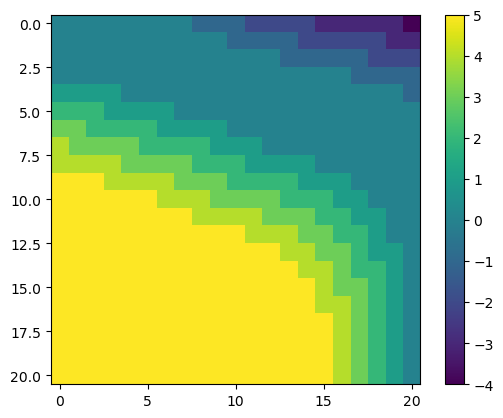

5 value evaluation
iteration 1 is done


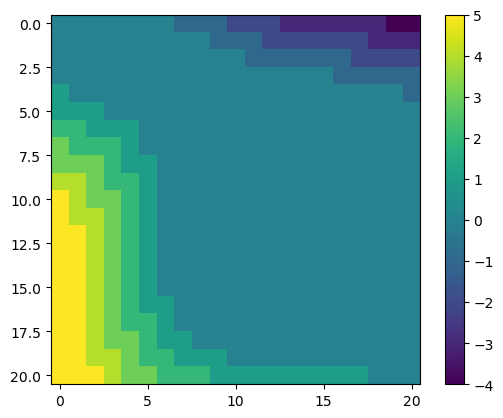

5 value evaluation
iteration 2 is done


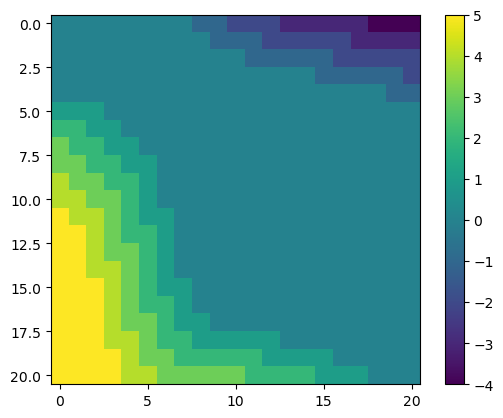

iteration 3 is done


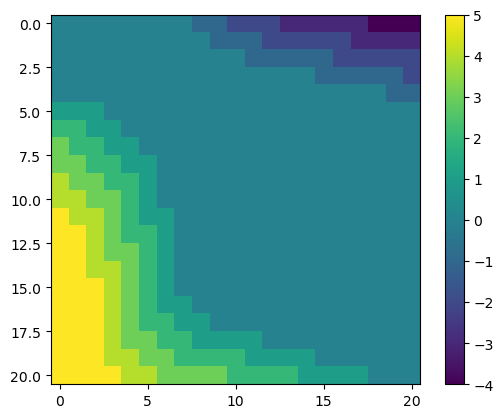

iteration 4 is done


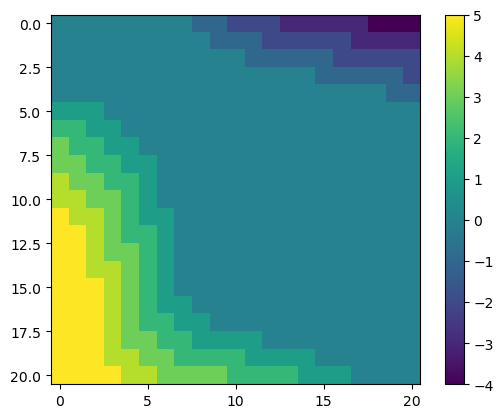

iteration 5 is done


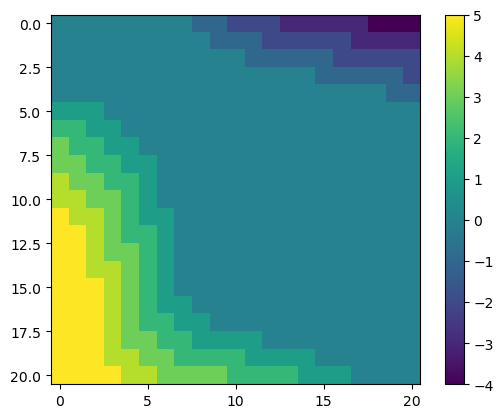

pi is stationary after 6 iteration


In [3]:
num_steps = 0
theta = 1
k = 1
old_v,new_v = V,policy_evaluation(V,pi)
old_pi,new_pi = pi,pi
while num_steps==0 or old_pi!=new_pi:
    while np.max(abs(old_v-new_v))>theta:
        new_v,old_v = policy_evaluation(new_v,new_pi),new_v
        if k%5==0:
            print(f'{k} value evaluation')
        k += 1
    new_pi,old_pi = policy_improvement(new_v),new_pi
    old_v,new_v = new_v,policy_evaluation(new_v,new_pi)
    k = 1
    print(f'iteration {num_steps} is done')
    # theta = 1/10**num_steps if num_steps<4 else 1e-3
    num_steps += 1
    maps = np.zeros((21,21))
    for i in range(21):
        for j in range(21):
            state = possible_transitions_states[i][j][0]
            policy = new_pi[i][j][0]
            ind = np.argmax(policy)
            maps[i,j] = i-state[ind][0]
    plt.imshow(maps)
    plt.colorbar()
    plt.show()
print(f'pi is stationary after {num_steps} iteration')

# value itaration

In [ ]:
num_steps = 0
k = 1
old_v,new_v = V,policy_evaluation(V,pi)
old_pi,new_pi = pi,pi
while num_steps==0 or old_pi!=new_pi:
    new_v,old_v = policy_evaluation(new_v,new_pi),new_v
    k += 1
    new_pi,old_pi = policy_improvement(new_v),new_pi
    old_v,new_v = new_v,policy_evaluation(new_v,new_pi)
    k = 1
    print(f'iteration {num_steps} is done')
    # theta = 1/10**num_steps if num_steps<4 else 1e-3
    num_steps += 1
    maps = np.zeros((21,21))
    for i in range(21):
        for j in range(21):
            state = possible_transitions_states[i][j][0]
            policy = new_pi[i][j][0]
            ind = np.argmax(policy)
            maps[i,j] = i-state[ind][0]
    plt.imshow(maps)
    plt.colorbar()
    plt.show()
print(f'pi is stationary after {num_steps} iteration')

In [3]:
import pandas as pd
import pickle

# pd.DataFrame(new_v).to_csv('Value.csv')
new_v = pd.read_csv('Value.csv',index_col=0).to_numpy()

# with open('policy.pkl', 'wb') as file:
#     pickle.dump(new_pi, file)

# 从文件加载列表
# with open('policy.pkl', 'rb') as file:
#     new_pi = pickle.load(file)

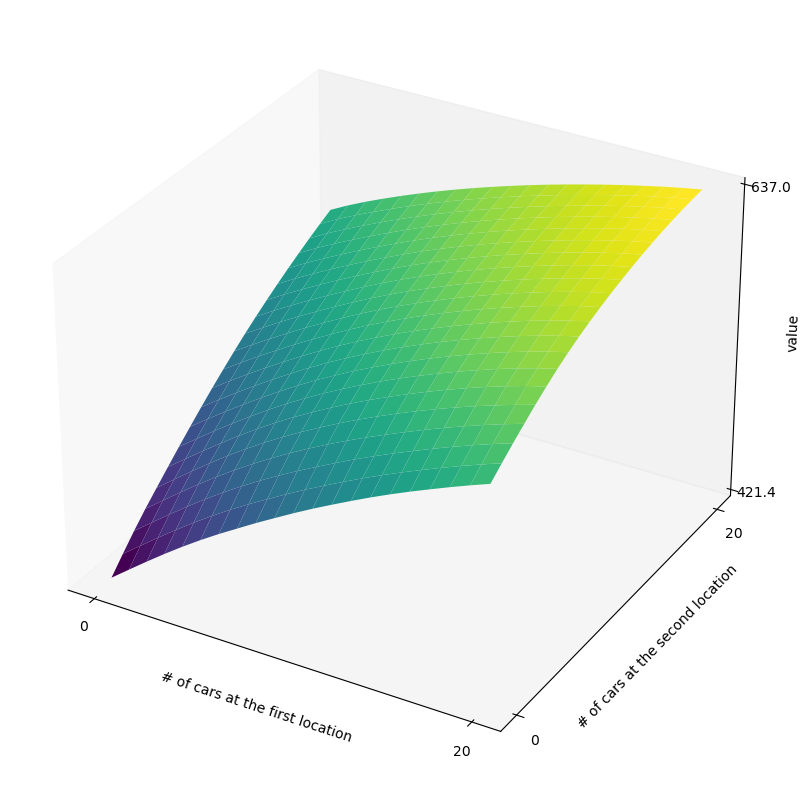

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(21)
y = np.arange(21)
X, Y = np.meshgrid(x, y)
Z = new_v 

# 创建 3D 图
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
# 绘制曲面
ax.plot_surface(X, Y, Z, cmap='viridis')

# 添加标签
ax.set_xlabel('# of cars at the first location')
ax.set_xticks([0,20])
ax.set_yticks([0,20])
ax.set_zticks([np.min(new_v),np.max(new_v)])
ax.set_ylabel('# of cars at the second location')
ax.set_zlabel('value')
# 显示图形
plt.show()
